# 12wk-2: (순환신경망) – RNNCell, RNN, LSTM, A1-A3

최규빈  
2025-05-26

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/12wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [171]:
#{{<video https://youtu.be/playlist?list=PLQqh36zP38-yfHwkWM_aHLQKTfKtoA7Oy&si=sgzwOEtflO1POup0 >}}

# 2. Imports

In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

# 3. Data – `AbAcAd`

`-` 데이터정리

In [4]:
txt = list('AbAcAd'*50)
txt[:10]

In [5]:
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
df_train[:5]

In [6]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [7]:
X.shape, y.shape

# 4. `rNNCell`

In [8]:
class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = torch.nn.Linear(4,2)
        self.h2h = torch.nn.Linear(2,2)
        self.tanh = torch.nn.Tanh()
    def forward(self,Xt,ht):
        return self.tanh(self.i2h(Xt)+self.h2h(ht))
torch.manual_seed(43052)
rnncell = rNNCell()
cook = torch.nn.Linear(2,4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters()),lr=0.1)
#---#
L = len(X)
for epoc in range(200):
    #1~2 
    loss = 0 
    ht = torch.zeros(2) # 맹물
    for t in range(L):
        Xt, yt = X[t],y[t]
        ht = rnncell(Xt,ht) #tanh(linr(xt)+linr(ht))
        ot = cook(ht)
        #yt_hat = soft(ot)
        loss = loss + loss_fn(ot, yt) 
    loss = loss/L 
    #3
    loss.backward()
    #4
    optimizr.step()
    optimizr.zero_grad()

`-` 결과 확인 및 시각화

In [9]:
h = torch.zeros(L,2)
water = torch.zeros(2)
h[0] = rnncell(X[0],water)
for t in range(1,L):
    h[t] = rnncell(X[t],h[t-1])
h.shape

In [10]:
yhat = torch.nn.functional.softmax(cook(h),dim=1)
yhat

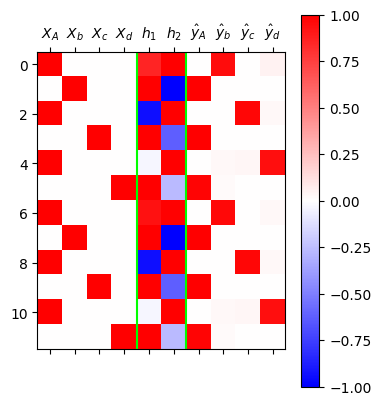

In [11]:
mat = torch.concat([X,h,yhat],axis=1).data
plt.matshow(mat[:12],cmap="bwr",vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(
    range(10),
    [r"$X_A$", r"$X_b$",r"$X_c$",r"$X_d$", 
     r'$h_1$',r'$h_2$',
     r'$\hat{y}_A$',r'$\hat{y}_b$',r'$\hat{y}_c$',r'$\hat{y}_d$']
);
plt.axvline(x=3.5,color='lime')
plt.axvline(x=5.5,color='lime')

# 5. `torch.nn.RNNCell`

ref: <https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html>

`-` `torch.nn.RNNCell`을 이용하여 학습

In [115]:
torch.manual_seed(0)
rnncell = torch.nn.RNNCell(4,2)
cook = torch.nn.Linear(2,4)
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters()),lr=0.1)

In [116]:
L = len(X)
for epoc in range(200):
    ## 1~2 
    ht = torch.zeros(2) 
    loss = 0
    for t in range(L):
        Xt, yt = X[t], y[t]
        ht = rnncell(Xt, ht)
        ot = cook(ht) 
        loss = loss + loss_fn(ot, yt)
    loss = loss/L
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [117]:
h = torch.zeros(L,2)
water = torch.zeros(2)
h[0] = rnncell(X[0],water)
for t in range(1,L):
    h[t] = rnncell(X[t],h[t-1])
yhat = torch.nn.functional.softmax(cook(h),dim=1)
yhat

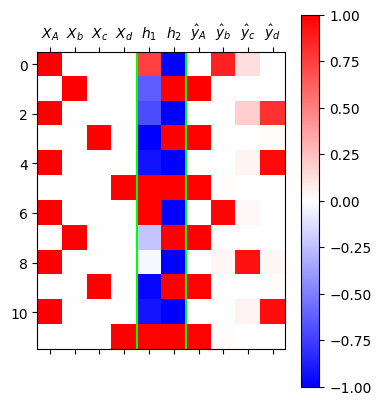

In [118]:
mat = torch.concat([X,h,yhat],axis=1).data
plt.matshow(mat[:12],cmap="bwr",vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(
    range(10),
    [r"$X_A$", r"$X_b$",r"$X_c$",r"$X_d$", 
     r'$h_1$',r'$h_2$',
     r'$\hat{y}_A$',r'$\hat{y}_b$',r'$\hat{y}_c$',r'$\hat{y}_d$']
);
plt.axvline(x=3.5,color='lime')
plt.axvline(x=5.5,color='lime')

`-` `torch.nn.RNNCell`의 가중치를 이전에 직접 설계한 `rNNCell`와
동일하게 설정한 이후 학습

-   왜 이런것을 하지? 우리가 직접만들어본 클래스 `rNNCell`이 torch에서
    기본제공하는 `torch.nn.RNNCell`와 동일기능을 수행한다는 것을
    확인하기 위함

In [119]:
torch.manual_seed(43052) 
_rnncell = rNNCell()
cook = torch.nn.Linear(2,4)

In [120]:
rnncell = torch.nn.RNNCell(4,2)
rnncell.weight_ih.data = _rnncell.i2h.weight.data 
rnncell.weight_hh.data = _rnncell.h2h.weight.data 
rnncell.bias_ih.data = _rnncell.i2h.bias.data 
rnncell.bias_hh.data = _rnncell.h2h.bias.data 

In [121]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters()),lr=0.1)

In [122]:
L = len(X)
for epoc in range(200):
    ## 1~2 
    ht = torch.zeros(2) 
    loss = 0
    for t in range(L):
        Xt, yt = X[t], y[t]
        ht = rnncell(Xt, ht)
        ot = cook(ht) 
        loss = loss + loss_fn(ot, yt)
    loss = loss/L
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [125]:
h = torch.zeros(L,2)
water = torch.zeros(2)
h[0] = rnncell(X[0],water)
for t in range(1,L):
    h[t] = rnncell(X[t],h[t-1])
yhat = torch.nn.functional.softmax(cook(h),dim=1)
yhat

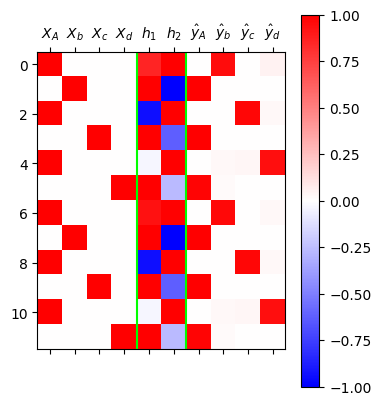

In [126]:
mat = torch.concat([X,h,yhat],axis=1).data
plt.matshow(mat[:12],cmap="bwr",vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(
    range(10),
    [r"$X_A$", r"$X_b$",r"$X_c$",r"$X_d$", 
     r'$h_1$',r'$h_2$',
     r'$\hat{y}_A$',r'$\hat{y}_b$',r'$\hat{y}_c$',r'$\hat{y}_d$']
);
plt.axvline(x=3.5,color='lime')
plt.axvline(x=5.5,color='lime')

# 6. `torch.nn.RNN`

ref: <https://docs.pytorch.org/docs/stable/generated/torch.nn.RNN.html>

|     | `RNNCell`, 배치사용 X | `RNNCell`, 배치사용 O |
|:---:|:---------------------:|:---------------------:|
|  X  |     $(L,H_{in})$      |   $(L, N, H_{in})$    |
|  h  |     $(L,H_{out})$     |   $(L, N, H_{out})$   |
|  y  |        $(L,Q)$        |      $(L, N, Q)$      |
| Xt  |      $(H_{in},)$      |     $(N, H_{in})$     |
| ht  |     $(H_{out},)$      |    $(N, H_{out})$     |
| yt  |        $(Q,)$         |        $(N,Q)$        |

|     |           `RNN`, 배치사용 X           |            `RNN`, 배치사용 O            |
|:----------------------:|:----------------------:|:----------------------:|
|  X  |             $(L,H_{in})$              |            $(L, N, H_{in})$             |
|  h  |             $(L,H_{out})$             |            $(L, N, H_{out})$            |
|  y  |                $(L,Q)$                |               $(L, N, Q)$               |
| hx  | $(D\times {\tt num\_layers},H_{out})$ | $(D\times {\tt num\_layers},N,H_{out})$ |

`-` `torch.nn.RNN`을 활용한 학습

In [75]:
torch.manual_seed(0)
rnn = torch.nn.RNN(
    input_size= 4, # X.shape=(299,4)
    hidden_size = 2, # h.shape=(299,2)
    num_layers = 1, # 우리수업에서는 그냥1 
    bidirectional = False # 우리수업에서는 항상 False
)
cook = torch.nn.Linear(2,4)
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()),lr=0.1)

In [76]:
D = 1 
n_of_layers = 1 
waters = torch.zeros(D*n_of_layers,2) 
for epoc in range(200):
    ## 1
    h, hL = rnn(X,waters) 
    out = cook(h)
    ## 2 
    loss = loss_fn(out,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [77]:
yhat = torch.nn.functional.softmax(out,dim=1)

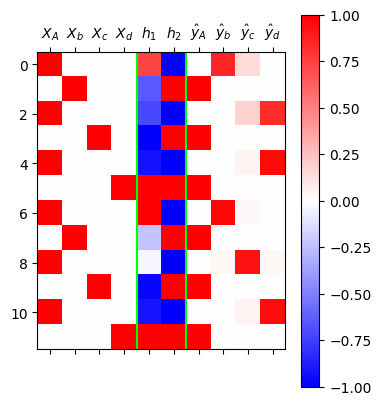

In [78]:
mat = torch.concat([X,h,yhat],axis=1).data
plt.matshow(mat[:12],cmap="bwr",vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(
    range(10),
    [r"$X_A$", r"$X_b$",r"$X_c$",r"$X_d$", 
     r'$h_1$',r'$h_2$',
     r'$\hat{y}_A$',r'$\hat{y}_b$',r'$\hat{y}_c$',r'$\hat{y}_d$']
);
plt.axvline(x=3.5,color='lime')
plt.axvline(x=5.5,color='lime')

`-` `torch.nn.RNN`의 가중치를 이전에 직접 설계한 `rNNCell`와 동일하게
설정한 이후 학습

In [146]:
torch.manual_seed(43052)
_rnncell = rNNCell()
cook = torch.nn.Linear(2,4)
rnn = torch.nn.RNN(
    input_size= 4, # X.shape=(299,4)
    hidden_size = 2, # h.shape=(299,2)
    num_layers = 1, # 우리수업에서는 그냥1 
    bidirectional = False # 우리수업에서는 항상 False
)
rnn.weight_hh_l0.data = _rnncell.h2h.weight.data 
rnn.weight_ih_l0.data = _rnncell.i2h.weight.data 
rnn.bias_hh_l0.data =  _rnncell.h2h.bias.data
rnn.bias_ih_l0.data =  _rnncell.i2h.bias.data
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()),lr=0.1)

In [150]:
D = 1 
n_of_layers = 1 
waters = torch.zeros(D*n_of_layers,2) 
for epoc in range(200):
    ## 1
    h, hL = rnn(X,waters) 
    out = cook(h)
    ## 2 
    loss = loss_fn(out,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [151]:
yhat = torch.nn.functional.softmax(out,dim=1)
yhat

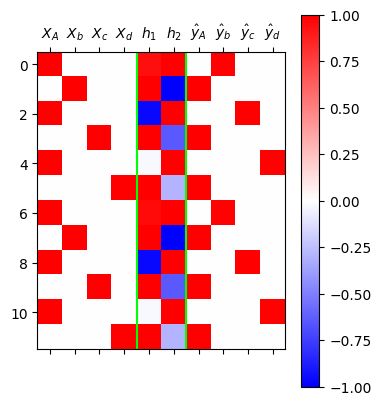

In [152]:
mat = torch.concat([X,h,yhat],axis=1).data
plt.matshow(mat[:12],cmap="bwr",vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(
    range(10),
    [r"$X_A$", r"$X_b$",r"$X_c$",r"$X_d$", 
     r'$h_1$',r'$h_2$',
     r'$\hat{y}_A$',r'$\hat{y}_b$',r'$\hat{y}_c$',r'$\hat{y}_d$']
);
plt.axvline(x=3.5,color='lime')
plt.axvline(x=5.5,color='lime')

# 7. `torch.nn.LSTM`

`-` `torch.nn.LSTM`을 이용하여 학습

In [166]:
torch.manual_seed(1)
lstm = torch.nn.LSTM(
    input_size= 4, # X.shape=(299,4)
    hidden_size = 2, # h.shape=(299,2)
    num_layers = 1, # 우리수업에서는 그냥1 
    bidirectional = False # 우리수업에서는 항상 False
)
cook = torch.nn.Linear(2,4)
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(lstm.parameters())+list(cook.parameters()),lr=0.1)

In [167]:
for epoc in range(200):
    ## 1
    h, _ = lstm(X) 
    out = cook(h)
    ## 2 
    loss = loss_fn(out,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [168]:
yhat = torch.nn.functional.softmax(out,dim=1)

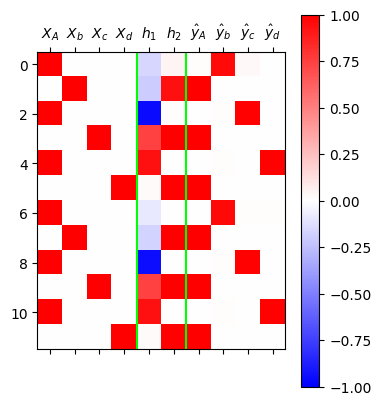

In [169]:
mat = torch.concat([X,h,yhat],axis=1).data
plt.matshow(mat[:12],cmap="bwr",vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(
    range(10),
    [r"$X_A$", r"$X_b$",r"$X_c$",r"$X_d$", 
     r'$h_1$',r'$h_2$',
     r'$\hat{y}_A$',r'$\hat{y}_b$',r'$\hat{y}_c$',r'$\hat{y}_d$']
);
plt.axvline(x=3.5,color='lime')
plt.axvline(x=5.5,color='lime')

# A1. 자잘한 용어 정리 ($\star$)

## A. ${\bf X}$, ${\bf y}$

`-` X, y를 지칭하는 이름

| 구분 | 용어                            | 설명                                                                                               |
|----------|-----------------------------------------------------|----------|
| X    | 설명변수                        | 종속변수(반응변수)를 설명하거나 예측하는 데 사용되는 변수로, 전통 통계 및 머신러닝에서의 입력 역할 |
|      | 독립변수 (Independent Variable) | 전통적인 통계학 및 회귀 분석 문맥에서 사용됨                                                       |
|      | 입력변수 (Input Variable)       | 머신러닝 모델에서 입력 데이터로 사용되며, 특히 신경망 구조 등에서 많이 쓰임                        |
|      | 특징 / 특성 (Feature)           | 머신러닝, 데이터마이닝, 딥러닝 등에서 데이터를 구성하는 속성 또는 설명 변수로 사용됨               |
|      | 예측 변수 (Predictor)           | 예측 모델 설계 시 독립변수를 지칭하는 용어로, 모델링/통계 분석 문맥에서 흔히 사용됨                |
|      | 공변량 (Covariate)              | 실험 디자인, 특히 임상연구나 사회과학 연구에서 제어 변수로 사용됨                                  |
| y    | 반응변수                        | 독립변수의 영향을 받는 결과 변수로, 모델링이나 인과 추론에서 핵심적인 대상                         |
|      | 종속변수 (Dependent Variable)   | 전통 통계학과 회귀분석에서 사용되며, 독립변수의 영향을 받는 변수로 정의됨                          |
|      | 출력변수 (Output Variable)      | 머신러닝 및 딥러닝에서 모델의 예측 결과로 출력되는 값으로 사용됨                                   |
|      | 타겟 / 정답 (Target / Label)    | 지도학습에서 모델이 학습해야 하는 실제 정답값을 의미하며, 분류/회귀 문제에 공통적으로 사용됨       |

`-` 더 다양함: <https://ko.wikipedia.org/wiki/독립변수와_종속변수>

## B. 지도학습

`-` 우리가 수업에서 다루는 데이터는 주로 아래와 같은 느낌이다.

1.  데이터는 $(X,y)$의 형태로 정리되어 있다.

2.  $y$는 우리가 관심이 있는 변수이다. 즉 우리는 $y$를 적절하게 추정하는
    것에 관심이 있다.

3.  $X$는 $y$를 추정하기 위해 필요한 정보이다.

|           $X$           |           $y$            |        비고        |      순서      |               예시               |
|:------------:|:--------------:|:----------:|:----------:|:------------------:|
|       기온(온도)        | 아이스 아메리카노 판매량 |        회귀        |    상관없음    | 날씨가 판매량에 미치는 영향 분석 |
|          스펙           |        합격 여부         |      로지스틱      |    상관없음    |     입사 지원자의 합격 예측      |
|         이미지          |         카테고리         | 합성곱신경망 (CNN) |    상관없음    |      개/고양이 이미지 구분       |
|    유저, 아이템 정보    |           평점           |     추천시스템     |    상관없음    |        넷플릭스 영화 추천        |
| 처음 $m$개의 단어(문장) |  이후 1개의 단어(문장)   |  순환신경망 (RNN)  | 순서 상관 있음 |   챗봇, 문장 생성, 언어 모델링   |
| 처음 $m$개의 단어(문장) |         카테고리         |  순환신경망 (RNN)  | 순서 상관 있음 |        영화리뷰 감정 분류        |

`-` 이러한 문제상황, 즉 $(X,y)$가 주어졌을때 $X \to y$를 추정하는 문제를
supervised learning 이라한다.

## C. 모델이란?

`-` 통계학에서 모델은 y와 x의 관계를 의미하며 오차항의 설계를 포함하는
개념이다. 이는 통계학이 “데이터 = 정보 + 오차”의 관점을 유지하기
때문이다. 따라서 통계학에서 모델링이란

$$y_i = net(x_i) + \epsilon_i$$

에서 (1) 적절한 함수 $net$를 선택하는 일 (2) 적절한 오차항 $\epsilon_i$
을 설계하는일 모두를 포함한다.

`-` 딥러닝 혹은 머신러닝에서 모델은 단순히

$$y_i \approx net(x_i)$$

를 의미하는 경우가 많다. 즉 “model=net”라고 생각해도 무방하다. 이 경우
“모델링”이란 단순히 적절한 $net$을 설계하는 것만을 의미할 경우가 많다.

`-` 그래서 생긴일

-   통계학교재 특징: 분류문제와 회귀문제를 엄밀하게 구분하지 않는다.
    사실 오차항만 다를뿐이지 크게보면 같은 회귀모형이라는 관점이다.
    그래서 일반화선형모형(GLM)이라는 용어를 쓴다.
-   머신러닝/딥러닝교재 특징: 회귀문제와 분류문제를 구분해서 설명한다.
    (표도 만듦) 이는 오차항에 대한 기술을 모호하게 하여 생기는 현상이다.

## D. 학습이란?

`-` 학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
“규칙” 혹은 “원리”를 찾는 것이다.

-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
    “맵핑”을 찾는 것이다.
-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
    “함수”을 찾는 것이다. 즉 $y\approx f(X)$가 되도록 만드는 $f$를 잘
    찾는 것이다. (이 경우 “함수를 추정한다”라고 표현)
-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
    “모델” 혹은 “모형”을 찾는 것이다. 즉 $y\approx model(X)$가 되도록
    만드는 $model$을 잘 찾는 것이다. (이 경우 “모형을 학습시킨다”라고
    표현)
-   **학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는
    어떠한 “네트워크”을 찾는 것이다. 즉 $y\approx net(X)$가 되도록
    만드는 $net$을 잘 찾는 것이다. (이 경우 “네트워크를 학습시킨다”라고
    표현)**

`-` prediction이란 학습과정에서 찾은 “규칙” 혹은 “원리”를 $X$에 적용하여
$\hat{y}$을 구하는 과정이다. 학습과정에서 찾은 규칙 혹은 원리는
$f$,$model$,$net$ 으로 생각가능한데 이에 따르면 아래가 성립한다.

-   $\hat{y} = f(X)$
-   $\hat{y} = model(X)$
-   $\hat{y} = net(X)$

## E. $\hat{y}$를 부르는 다양한 이름

`-` $\hat{y}$는 $X$가 주어진 자료에 있는 값인지 아니면 새로운 값 인지에
따라 지칭하는 이름이 미묘하게 다르다.

1.  $X \in data$: $\hat{y}=net(X)$ 는 predicted value, fitted value 라고
    부른다.

2.  $X \notin data$: $\hat{y}=net(X)$ 는 predicted value, predicted
    value with new data 라고 부른다.

## F. 다양한 코드들

`-` 파이썬 코드..

``` python
#Python
predictor.fit(X,y) # autogluon 에서 "학습"을 의미하는 과정
model.fit(X,y) # sklearn 에서 "학습"을 의미하는 과정
trainer.train() # huggingface 에서 "학습"을 의미하는 과정
trainer.predict(dataset) # huggingface 에서 "예측"을 의미하는 과정
model.fit(x, y, batch_size=32, epochs=10) # keras에서 "학습"을 의미하는 과정
model.predict(test_img) # keras에서 "예측"을 의미하는 과정 
```

`-` R 코드..

``` r
# R
ols <- lm(y~x) # 선형회귀분석에서 학습을 의미하는 함수
ols$fitted.values # 선형회귀분석에서 yhat을 출력 
predict(ols, newdata=test) # 선형회귀분석에서 test에 대한 예측값을 출력하는 함수
ols$coef # 선형회귀분석에서 weight를 확인하는 방법
```

# A2. 신경망관련 용어

`-` 은근히 용어가 헷갈리는데, 뜻을 좀 살펴보자.

-   ANN: 인공신경망
-   MLP: 다층퍼셉트론 (레이어가 여러개 있어요)
-   DNN: 깊은신경망, 심층신경망
-   CNN: 합성곱신경망
-   RNN: 순환신경망

`# 예시1` – MLP, DNN

``` python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=1),    
    torch.nn.Sigmoid()
)
```

-   ANN: O
-   MLP: O
-   DNN: O
-   CNN: X (합성곱레이어가 없으므로)
-   RNN: X (순환구조가 없으므로)

`#`

`# 예시2` – MLP, Shallow Network

``` python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=1),
    torch.nn.Sigmoid()
)
```

-   ANN: O
-   MLP: O
-   DNN: X (깊은 신경망으로 생각하려면 더 많은 레이어가 필요함. 합의된
    기준은 히든레이어 2장이상, 이걸 설명하기 위해서 얕은 신경망이란
    용어도 씀)
-   CNN: X (합성곱레이어가 없으므로)
-   RNN: X (순환구조가 없으므로)

`#`

`# 예시3` – MLP, DNN, Wide NN

``` python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=1048576),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=1048576,out_features=1048576),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=1048576,out_features=1),
    torch.nn.Sigmoid(),    
)
```

-   ANN: O
-   MLP: O
-   DNN: O (깊긴한데 이정도면 모양이 깊다기 보다는 넓은 신경망임, 그래서
    어떤 연구에서는 이걸 넓은 신경망이라 부르기도 함)
-   CNN: X (합성곱레이어가 없으므로)
-   RNN: X (순환구조가 없으므로)

`# 예시4` – CNN

``` python
net = torch.nn.Sequential(
    # Layer1
    torch.nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.LeakyReLU(0.2),
    # Layer2
    torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(128),
    torch.nn.LeakyReLU(0.2),
    # Layer3
    torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(256),
    torch.nn.LeakyReLU(0.2),
    # Layer4
    torch.nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(512),
    torch.nn.LeakyReLU(0.2),
    # Layer5
    torch.nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    torch.nn.Sigmoid(),
    torch.nn.Flatten()
)
```

-   ANN: O
-   MLP: X (합성곱연결이 포함되어있으므로, MLP가 아님, 완전연결만
    포함해야 MLP임)  
-   DNN: O
-   CNN: O (합성곱레이어를 포함하고 있으므로)
-   RNN: X (순환구조가 없으므로)

`#`

`# 예시5` – CNN

``` python
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    torch.nn.Sigmoid()
)
```

-   ANN: O
-   MLP: X
-   DNN: X? (히든레이어가 1장이므로..)
-   CNN: O (합성곱레이어를 포함하고 있으므로)
-   RNN: X (순환구조가 없으므로)

> 근데 대부분의 문서에서는 CNN, RNN은 DNN의 한 종류로 설명하고
> 있어서요.. 이런 네트워크에서는 개념충돌이 옵니다.

`#`

`# 예시6` – RNN

``` python
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = torch.nn.RNN(4,2)
        self.linr = torch.nn.Linear(2,2) 
    def forward(self,X):
        h,_ = self.rnn(X) 
        netout = self.linr(h)
        return netout 
net = Net()     
```

-   ANN: O
-   MLP: X
-   DNN: X? (히든레이어가 1장이므로..)
-   CNN: X (합성곱레이어가 없으므로)
-   RNN: O

> 이것도 비슷한 개념충돌

`#`

# A3. 학습

`-` 모든 인공지능 관련 알고리즘은 아래의 분류로 가능함.

|      **특징**       | **지도학습 (Supervised Learning)** | **비지도학습 (Unsupervised Learning)** | **강화학습 (Reinforcement Learning)**  |
|:----------:|:------------------:|:-------------------:|:------------------:|
|      **정의**       | 입력 데이터와 정답(레이블)을 사용  |           입력 데이터만 사용           |  에이전트가 환경과 상호작용하며 학습   |
|      **목표**       |   입력에 대한 정확한 출력을 예측   |    데이터의 숨겨진 구조나 패턴 발견    | 최대 보상을 얻기 위한 최적의 정책 학습 |
|      **예시**       |      이미지 분류, 스팸 필터링      |           군집화, 차원 축소            |         게임 플레이, 로봇 제어         |
|  **주요 알고리즘**  |   선형 회귀, 로지스틱 회귀, SVM    |        K-평균, PCA, 오토인코더         |              Q-러닝, DQN               |
|      **활용**       |             분류, 예측             |       데이터의 숨겨진 패턴 발견        |     복잡한 의사결정 문제 해결 가능     |
| **데이터 요구사항** |       레이블링이 반드시 필요       |         많은 양의 데이터 필요          |     시뮬레이션 또는 실제 환경 필요     |

`-` 그런데 분류가 애매한 것들이 점점 많아짐.